In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

import time

# from sklearn import gaussian_process
# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
from scipy.interpolate import PchipInterpolator

In [5]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-
#smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/
    savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

# def return_arr_to_orig(time_array,orig_time):
#     return_arr = []
# #     orig_time = savgol_filtered_oband['mjd']-mjd_scale
#     for datapt in time_array:
#         matched_time_ind = np.argmin(np.abs(orig_time-datapt))
#         return_arr.append(orig_time[matched_time_ind])
#     return_arr = np.asarray(return_arr)
#     return return_arr

# def err_calculation(time_arr,orig_time):
# #     orig_time = savgol_filtered_oband['mjd']-mjd_scale
# #     print(len(orig_time))
#     err_arr = []
#     for time in time_arr:
#         matched_time_ind = np.argmin(np.abs(orig_time-time))
# #         print(matched_time_ind)
#         if matched_time_ind != 0 and matched_time_ind > 5 and matched_time_ind < (len(orig_time)-6):
# #             print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
#             err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
#         elif matched_time_ind > (len(orig_time)-6):
# #             print('end of arr')
#             err_arr.append(np.nan)
#         else:
# #             print('beginning of arr')
#             err_arr.append(np.nan)
#     err_arr = np.asarray(err_arr)
#     return err_arr

In [6]:

def decline_detection(data_frame,decline_min_depth=0.9,saturation_limit=12,
                      use_iter_smooth=False,debug_mode=False,savefile=None):
    ##############################################
    ## note that the DataFrame must have a 'jd' column and a 'mag' column
    ##############################################

    ##############################################
    ## zeropoint so we don't have to do it forever
    ##############################################
    mjd_scale = data_frame['jd'][0]

    ##############################################
    ## apply a savgol filter to remove outliers
    ##############################################
    ### will fail if duplicate data points
    savgol_filtered = non_uniform_savgol(np.asarray(data_frame['jd']-mjd_scale),
                                         np.asarray(data_frame['mag']),
                                       window=7, polynom=1)
    
    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,data_frame['mag'],s=10,
                    c=savgol_filtered-data_frame['mag'],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.colorbar(label='savgol residual')
        plt.title('Savgol residual on original data')
        # plt.clim(vmax=-1)
        plt.clim(vmin=-2)
        plt.show()

    ## measure the std deviation of the savgol filtering
    ## we will kick out data points with residuals bigger than this
    deviation = np.std(savgol_filtered-data_frame['mag'])
    percentile = np.percentile(savgol_filtered-data_frame['mag'],95)
    percentile2 = np.percentile(savgol_filtered-data_frame['mag'],99)
    if debug_mode==True:
        print('Std dev:',deviation)
        print('95 percentile:',percentile)
        print('99 percentile:',percentile2)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,savgol_filtered-data_frame['mag'],s=10)
        plt.axhline(deviation,color='k',linestyle='--')
        plt.axhline(-deviation,color='k',linestyle='--')
        plt.axhline(percentile,color='red',linestyle='--')
        plt.axhline(-percentile,color='red',linestyle='--')
        plt.axhline(percentile2,color='green',linestyle='--')
        plt.axhline(-percentile2,color='green',linestyle='--')
        # plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('residuals to savgol filter')
        plt.title('savgol filter residuals with the cutoff labelled')
        plt.ylim(-1,1)
        plt.show()

    ## the actual mask for the savgol filtering
    mask = np.where(np.abs(savgol_filtered-data_frame['mag'])<percentile,True,False)
    ## add in a mask for bad measurements 1.5 mag above the saturation limit
    mask_satlim = np.where(data_frame['mag']<saturation_limit-1.5,False,True)
    mask = mask & mask_satlim

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd'][mask]-mjd_scale,data_frame['mag'][mask],s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.title('Savgol filtered data')
        plt.show()

    ## apply the mask for savgol filtering
    savgol_filtered_frame = data_frame.iloc[mask]
    savgol_filtered_frame.reset_index(drop=True,inplace=True)
    # savgol_filtered_oband
    if savgol_filtered_frame['jd'][0] != mjd_scale:
        print('filtered first data point, resetting mjd_scale')
        mjd_scale = savgol_filtered_frame['jd'][0]

    ##############################################
    ## savgol filter to smooth the data
    ##############################################
    ## make another, more aggressive savgol filter to smooth the data
    iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                         np.asarray(savgol_filtered_frame['mag']),
                                       window=31, polynom=1)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,
                    c=iter_savgol_filtered-savgol_filtered_frame['mag'],cmap='bwr')
        plt.colorbar(label='iterated savgol residual')
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5,color='k')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        plt.title('Savgol for smoothing (iter)')
        plt.show()

    ##############################################
    ## create a mask for the regions which are saturated
    ## this will need to be edited for things that aren't ATLAS
    ##############################################
    # I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
    # and limiting mag is ~20
    local_std = np.std((iter_savgol_filtered-savgol_filtered_frame['mag']))
#     saturation_limit = 0#12
    saturation_mask = []
#     variation_arr = []
    halfwidth=10
#     print('saturation_masking')
#     print('savgol length:',len(savgol_filtered_frame))
#     print('iter length:',len(iter_savgol_filtered))
    for i in range(0,len(savgol_filtered_frame)):
#         print(i)
        if i > int(len(savgol_filtered_frame)-halfwidth-1):
            saturation_mask.append(True)
#             print('end of array')
#             variation_arr.append(0)
        elif int(i < halfwidth):
            saturation_mask.append(True)
#             print('beginning of array')
#             variation_arr.append(0)
        else:
            variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth]))
            time_res = savgol_filtered_frame['jd'][i+halfwidth] - savgol_filtered_frame['jd'][i-halfwidth]
            #             variation_arr.append(variation_window)
#             print('variation window',variation_window)
            if (variation_window > 0.1 and time_res < 50 and
                np.mean(savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth])<saturation_limit):
#                 time_res = savgol_filtered_frame['jd'][i+halfwidth] - savgol_filtered_frame['jd'][i-halfwidth]
#                 print('time res', time_res)
        #         print('mask me')
                saturation_mask.append(False)
            else:
                saturation_mask.append(True)
#     variation_arr = np.asarray(variation_arr)
    saturation_mask = np.asarray(saturation_mask)

    if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,alpha=0.5)
#         plt.scatter(savgol_filtered_frame['jd'][saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][saturation_mask],s=10,
#                     c=variation_arr[:-1],cmap='bwr')
#         # plt.scatter(savgol_filtered_frame['jd'][np.invert(saturation_mask)]-mjd_scale,
#         #            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
#         plt.colorbar(label='variation window')
#         plt.clim(-0.5,0.5)
#         # plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('savgol filtered magnitude')
#         plt.title('checking the variation window argument for saturation masking')
#         # plt.colorbar(label='iterated savgol residual')
#         # plt.clim(vmax=-1)
#         # plt.clim(vmin=-2)
#         plt.show()
        
        
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,alpha=0.5)
        plt.scatter(savgol_filtered_frame['jd'][saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][saturation_mask],s=10,
                    c=iter_savgol_filtered[saturation_mask]-savgol_filtered_frame['mag'][saturation_mask],cmap='bwr')
        plt.colorbar(label='iterated savgol residual')
        plt.clim(-1,1)
        plt.scatter(savgol_filtered_frame['jd'][~saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][~saturation_mask],
                    s=10,color='k')
        # plt.scatter(savgol_filtered_frame['jd'][np.invert(saturation_mask)]-mjd_scale,
        #            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
        # plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        # plt.colorbar(label='iterated savgol residual')
#         plt.clim(vmin=-2)
        plt.show()



    ##############################################
    ## decide on the iter smooth or the original data
    ##############################################
    if use_iter_smooth==True:
        ## make another, more aggressive savgol filter to smooth the data
        iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                             np.asarray(savgol_filtered_frame['mag']),
                                           window=7, polynom=1)
#         savgol_filtered_frame['mag'] = iter_savgol_filtered


    ##############################################
    ## interpolate the data to get evenly sampled data
    ##############################################
    # interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(iter_savgol_filtered),
    #                                                  kind='linear')
    if use_iter_smooth==True:
        interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                                         np.asarray(iter_savgol_filtered),
                                                         kind='linear')
    else:
        interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                                         np.asarray(savgol_filtered_frame['mag']),
                                                         kind='linear')

    ### attempting monotone interpolants ###
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(iter_savgol_filtered)) # this one is better
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(savgol_filtered_frame['mag'])) # this one is better


    ## what time resolution? I don't want to lose any of the real data if possible
    real_resolution = np.average(np.diff(savgol_filtered_frame['jd']))
    if debug_mode==True:
        print('data resolution:', real_resolution)
    len_data = np.max(savgol_filtered_frame['jd']-mjd_scale)
    resample_time = np.linspace(0,len_data,int(len_data)) # declines don't matter closer than this
    ## currently resampling at a resolution of 1 day
    resample_flux = interpolation_function(resample_time)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(savgol_filtered_frame['mag']),s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('resampled jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.title('checking the interpolation method with the smooth/orig data')
        # plt.ylim(20.5,11)
        # plt.ylim(14,11)
        # plt.xlim(1000,1200)
        plt.show()

#     ##############################################
#     ## edge detection via convolution - this is identical to gradient but slower
#     ##############################################
#     start = time.time()
#     new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])
#     end = time.time()
#     print('convolution edges time:', end - start)

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,new_edge_detect,s=10)
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('edge detection')
#         plt.title('edge detection via convolution')
#         # plt.ylim(-1,1)
#         plt.show()

#         plt.figure(figsize=(14,6))
#         # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,
#                     c=new_edge_detect,cmap='bwr')#,alpha=0.2)
#         # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
#         plt.gca().invert_yaxis()
#         plt.xlabel('resampled jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.colorbar(label='edge detect')
#         plt.clim(-0.1,0.1)
#         plt.title('plotting edge detection via convolution on the original data')
#         plt.show()

#     ##############################################
#     ## creating a mask for when edge detect is positive
#     ##############################################
#     # std_dev = np.std(new_edge_detect)
#     # # std_dev
#     # new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
#     new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
#         plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
#                     c=new_edge_detect[new_mask],cmap='bwr')
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.colorbar(label='edge detect')
#         plt.title('positive in edge detection via convolution')
#         plt.clim(-0.1,0.1)
#         # plt.xlim(950,1200)
#         # plt.xlim(500,1000)
#         plt.show()

#     ##############################################
#     ## create mask for edge detection significantly positive
#     ##############################################
#     std_dev = np.std(new_edge_detect)
#     new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
#     downslope_mask = np.where(new_edge_detect>0.0,True,False)
#     total_mask = new_mask & downslope_mask

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
#         plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#                     c=new_edge_detect[total_mask],cmap='bwr')
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.title('masked for edge detection significantly positive')
#         plt.colorbar(label='edge detect')
#         plt.clim(-0.1,0.1)
#         # plt.xlim(950,1200)
#         # plt.xlim(500,1000)
#         plt.show()

    ##############################################
    ## edge detection via gradients
    ##############################################
#     start = time.time()
    gradient = np.gradient(resample_flux, resample_time)
    smooth_gradient = non_uniform_savgol(resample_time,
                                        gradient,
                                        window=7, polynom=1)
#     smooth_gradient = convolve(gradient, Box1DKernel(7))
    second_gradient = np.gradient(smooth_gradient, resample_time)
#     end = time.time()
#     print('gradient edges time:', end - start)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('gradient')
        plt.title('the gradient')
        plt.ylim(-0.25,0.25)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,smooth_gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('smooth gradient')
        plt.title('the smoothed gradient')
        plt.ylim(-0.25,0.25)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,second_gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('second gradient')
        plt.title('the second gradient')
#         plt.ylim(-0.25,0.25)
        plt.show()

#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,(gradient/np.max(gradient))-(new_edge_detect/np.max(new_edge_detect)),s=10)
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('diff between gradient and convolution edges')
#         plt.ylim(-0.25,0.25)
#         plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,
                    c=gradient,cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('edge detection via the gradient')
        plt.clim(-0.1,0.1)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,
                    c=smooth_gradient,cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='smooth gradient')
        plt.title('edge detection via the smoothed gradient')
        plt.clim(-0.1,0.1)
        plt.show()
        
#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,gradient,s=15,
#                     c=second_gradient,cmap='bwr',edgecolor='k',linewidth=0.5)
# #         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('gradient')
#         plt.colorbar(label='second gradient')
#         plt.title('gradient with the second gradient')
#         plt.clim(-0.1,0.1)
#         plt.xlim(1500,2000)
#         plt.show()

    ##############################################
    ## mask for where gradient is positive
    ##############################################
    downslope_mask = np.where(smooth_gradient>0,True,False)
#     downslope_mask = np.where(gradient>0,True,False)
    total_mask = downslope_mask

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
                    c=gradient[downslope_mask],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('positive gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()

    ##############################################
    ## find the runs of positive and negative values
    ##############################################
    run_vals, run_start, run_length = find_runs(total_mask)

    downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
    upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

    ## generation of the actual decline onsets
    ## this is the meat of the code
    if debug_mode==True:
        print('actually detecting the declines')
#     decline_min_depth = 0.9
    decline_onset = []
    decline_end = []
    decline_depth = []
    for i in range(0,len(resample_flux[run_start])):
        ####################################################################
        if i == 0 and resample_flux[0] > (np.min(resample_flux)+decline_min_depth):
            # and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
            ## two possible cases: either starts going down or starts going up
            ## either way, they should BOTH start below the decline threshold
            ## adding the absolute magnitude should detect beginning declines
            ## NEEDS TO BE TESTED - has been tested a little bit, needs more
            decline_onset.append(0)
            if debug_mode==True:
                print('beginning i=0')
                print(resample_flux[0])
#                 print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
            decline_end.append(run_start[i+1])
            decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
            ####################################################################
        elif i == len(resample_flux[run_start])-1:
            if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
                decline_onset.append(run_start[i])
                if debug_mode==True:
                    print('end')
                    print(run_start[i])
                    print(resample_flux[run_start[i]])
                    print(resample_flux[-1] - resample_flux[run_start[i]])
                decline_end.append(len(resample_flux)-1)
                decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
        elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
            decline_onset.append(run_start[i])
            if debug_mode==True:
                print(run_start[i])
                print(resample_flux[run_start[i]])
                print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
            decline_end.append(run_start[i+1])
            decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
    #     if i == len(resample_flux[run_start]):
    #         print('end')
    if debug_mode==True:
        print(resample_flux[decline_end])
        print(decline_depth)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downward_mask],
                    np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[upward_mask],
                    np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='tab:green',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.clim(-0.1,0.1)
        plt.title('all the original run masks')
        plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[decline_onset],
                    np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('the better run masks with the gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()

    ## more of the meat here
    ## turning the masks into real data points
    plt.figure(figsize=(14,6))
    plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')
    plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
    plt.clim(-0.1,0.1)

    onset_arr = []
    onset_flag = []
    max_depth_arr = []
    end_arr = []
    end_flag = []

    max_light = np.min(resample_flux)
    plt.axhline(max_light,color='k',linestyle='--')
    plt.axhline(max_light+decline_min_depth,color='k',linestyle='--',alpha=0.5)
    for i in range(0,len(resample_time[decline_onset])):
        flag_set = False
        if decline_onset[i] == 0:
    #         print('beginning of array')
            onset_flag.append(1)
            flag_set = True
        onset_time = resample_time[decline_onset][i]
        diff_arr = np.abs((savgol_filtered_frame['jd'][saturation_mask]-mjd_scale)-onset_time)
        diff_arr_normal = np.abs((savgol_filtered_frame['jd']-mjd_scale)-onset_time)
#         if debug_mode == True:
#             print('min diff_arr',np.min(diff_arr))
#             print('min diff_arr_normal',np.min(diff_arr_normal))
        if np.min(diff_arr) > 5:
            if decline_depth[i] > decline_min_depth+1:#12-np.min(savgol_filtered_frame['mag']):
                plt.axvline(onset_time,color='red',linestyle='--')
                plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #             plt.axhline(max_light+decline_min_depth+decline_depth[i],color='k',linestyle='--')
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                if flag_set == False:
                    onset_flag.append(2)
    #             print('onset', onset_time)
            else:
                if debug_mode == True:
                    print('bad onset')
                plt.axvline(onset_time,color='k',linestyle='--')
                onset_flag.append(3)
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                pass
    #             plt.axvline(onset_time,color='red',linestyle='--')
        else:
            plt.axvline(onset_time,color='green',linestyle='--',alpha=0.5)
            plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #         plt.axhline(max_light+decline_min_depth+decline_depth[i],linestyle='--')
            if flag_set == False:
                onset_flag.append(0)
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
    #         print('onset', onset_time)

        post_decline_time = resample_time[resample_time>onset_time]
        post_decline_flux = resample_flux[resample_time>onset_time]
        xx = 0
        while post_decline_flux[xx] < (max_light+decline_min_depth):
            xx=xx+1
        else:
    #         print('exited max light')
            exit_time = post_decline_time[xx]
            post_decline_time = resample_time[resample_time>exit_time]
            post_decline_flux = resample_flux[resample_time>exit_time]

        xx = 0
        try:
            while post_decline_flux[xx] > (max_light+decline_min_depth):
                xx=xx+1
            else:
    #             print('reached max light')
    #             print(xx,post_decline_flux[xx],post_decline_time[xx])
                if onset_flag[-1] != 3:
                    plt.axvline(post_decline_time[xx],color='blue',linestyle='--',alpha=0.5)
                end_arr.append(post_decline_time[xx])
                end_flag.append(0)
        except IndexError:
    #         print('reached end of array')
    #         print(xx-1,post_decline_flux[xx-1],post_decline_time[xx-1])
            if onset_flag[-1] != 3:
                plt.axvline(post_decline_time[xx-1],color='blue',linestyle='--',alpha=0.5)
            end_arr.append(post_decline_time[xx-1])
            end_flag.append(1)

    # print(onset_arr)
    # print(onset_flag)
    # print(end_arr)
    # print(end_flag)
    # print(max_depth_arr)

    plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
                np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
                        s=20,marker='x',color='k',zorder=3)

    for i in range(0,len(onset_arr)):
        if onset_flag[i] != 3:
            plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    plt.title('setting the onsets and the flags')
    plt.show()

    ## resample the times back to the original data set
    orig_time = savgol_filtered_frame['jd']-mjd_scale
    print('onsets')
    onset_arr_orig = return_arr_to_orig(onset_arr,orig_time,savgol_filtered_frame['mag'],
                                        onset_flag,arr_type='onset')
    print('ends')
    end_arr_orig = return_arr_to_orig(end_arr,orig_time,savgol_filtered_frame['mag'],
                                      onset_flag,arr_type='end')
    depth_time_orig = return_arr_to_orig(max_depth_arr,orig_time,savgol_filtered_frame['mag'],
                                         onset_flag,arr_type='depth')

    ## calculate errors
    onset_err_arr = err_calculation(onset_arr_orig,orig_time)
    end_err_arr = err_calculation(end_arr_orig,orig_time)
    depth_err_arr = err_calculation(depth_time_orig,orig_time)
    
    
    ##############################################
    ## refine the decline onset calculation
    ##############################################
    (new_onset_arr_orig,
    new_onset_err_arr)= refine_onset_times(onset_arr_orig,
                                           onset_flag,
                                           resample_time,
                                           resample_flux,
                                           orig_time,
                                           savgol_filtered_frame['mag'],
                                           smooth_gradient,second_gradient,
                                           debug_mode=debug_mode)
    
    ## the original ones are better 
    ## (but I still want to see the refining plots in debug mode)
    new_onset_arr_orig = onset_arr_orig
    new_onset_err_arr = onset_err_arr
    
    
    ##############################################
    ## refine the decline minima
    ##############################################
    (new_depth_time_orig,
     new_depth_err_arr,
     new_decline_depth,
     new_decline_min_mag,
     onset_flag) = refine_decline_minima(new_onset_arr_orig,
                                         onset_flag,
                                         end_arr_orig,
                                         resample_time,
                                         resample_flux,
                                         orig_time,
                                         savgol_filtered_frame['mag'],
                                         debug_mode=debug_mode,
                                         decline_min_depth=decline_min_depth)

    

    ## plot the errorbars
    plt.figure(figsize=(14,6))
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')

    plt.errorbar(x=new_onset_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
                 xerr=new_onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')

    plt.errorbar(x=end_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
                 xerr=end_err_arr[np.asarray(onset_flag) != 3],fmt='o')

    plt.errorbar(x=new_depth_time_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(new_depth_time_orig[np.asarray(onset_flag) != 3]),np.max(resample_flux))+0.4,
                 xerr=new_depth_err_arr[np.asarray(onset_flag) != 3],fmt='o')


    for onset_time in new_onset_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')

    for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

    for i in range(0,len(new_onset_arr_orig)):
        if onset_flag[i] != 3:
            plt.axvspan(new_onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    if savefile != None:
        plt.title(savefile)
        plt.savefig(savefile,bbox_inches='tight',dpi=300)
    plt.title('showing the errors on the all of the times')
    plt.show()

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,smooth_gradient,s=10,color='tab:red')
        plt.scatter(new_onset_arr_orig[np.asarray(onset_flag) != 3],
                    np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                            s=20,marker='x',color='k',zorder=3)

        plt.errorbar(x=new_onset_arr_orig[np.asarray(onset_flag) != 3],
                    y=np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                     xerr=new_onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')

        for onset_time in new_onset_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
        for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

        for i in range(0,len(new_onset_arr_orig)):
            if onset_flag[i] != 3:
                plt.axvspan(new_onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')
                
        plt.axhline(0.0,color='k',linestyle='--')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('smoothed gradient')
        plt.title('the gradient and the errors')
        plt.show()

    ##############################################
    ## save all the data in a dataframe
    ##############################################
#     decline_arr = np.array([onset_arr_orig,onset_err_arr,onset_flag,
#                             end_arr_orig,end_err_arr,end_flag,
#                             depth_time_orig,depth_err_arr,
#                             decline_depth,resample_flux[decline_end]])
    decline_arr = np.array([new_onset_arr_orig+mjd_scale,new_onset_err_arr,onset_flag,
                            end_arr_orig+mjd_scale,end_err_arr,end_flag,
                            new_depth_time_orig+mjd_scale,new_depth_err_arr,
                            new_decline_depth,new_decline_min_mag])
    decline_frame = pd.DataFrame(decline_arr.T,
                                 columns=['onset_time','onset_err','onset_flag','end_time','end_err',
                                          'end_flag','depth_time','depth_err','decline_depth','min_mag'])
    if debug_mode==True:
        print(decline_frame)
    return decline_frame

In [7]:
def return_arr_to_orig(time_array,orig_time,orig_flux,arr_flag,arr_type):
    return_arr = []
    width=10
    real_res = np.average(np.diff(orig_time))
#     orig_time = savgol_filtered_oband['mjd']-mjd_scale
    for i in range(0,len(time_array)):#datapt in time_array:
        matched_time_ind = np.argmin(np.abs(orig_time-time_array[i]))
        if (arr_type == 'onset' and 
            (orig_flux[matched_time_ind+width]<(np.min(orig_flux)+1.5)) and 
            (orig_flux[matched_time_ind]<(np.min(orig_flux)+1.5)) and
            arr_flag[i]!=3):
#             print('matched_time_ind',matched_time_ind)
#             print('around there',orig_time[matched_time_ind:matched_time_ind+width])
#             print('gap size ',real_res*6)
            if (orig_time[matched_time_ind+width] - orig_time[matched_time_ind]) > real_res*6:
                print('decline',i,'big gap, changing index')
                xx = 1
                ## find where the jump is
                while (orig_time[matched_time_ind+xx]-orig_time[matched_time_ind])<real_res*6:
#                     print(xx,'still small')
                    xx=xx+1
                print(np.diff(orig_time[matched_time_ind:matched_time_ind+width]))
                matched_time_ind = matched_time_ind+xx
#         elif arr_type == 'end':
# #             print('matched_time_ind',matched_time_ind)
# #             print('around there',orig_time[matched_time_ind-5:matched_time_ind+5])
# #             print('gap size ',real_res*6)
#             if (orig_time[matched_time_ind] - orig_time[matched_time_ind-5]) > real_res*6:
#                 print('big gap')
        return_arr.append(orig_time[matched_time_ind])
    return_arr = np.asarray(return_arr)
    return return_arr

def err_calculation(time_arr,orig_time):
#     orig_time = savgol_filtered_oband['mjd']-mjd_scale
#     print(len(orig_time))
    width = 10
    err_arr = []
    for time in time_arr:
        matched_time_ind = np.argmin(np.abs(orig_time-time))
#         print(matched_time_ind)
        if matched_time_ind != 0 and matched_time_ind > width and matched_time_ind < (len(orig_time)-width-1):
#             print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
            err_arr.append((orig_time[matched_time_ind+width]-orig_time[matched_time_ind-width])/2)
        elif matched_time_ind > (len(orig_time)-1-width):
#             print('end of arr')
            err_arr.append(np.nan)
        else:
#             print('beginning of arr')
            err_arr.append(np.nan)
    err_arr = np.asarray(err_arr)
    return err_arr

In [26]:
def refine_decline_minima(onset_array,onset_flag_arr,end_array,interp_time,interp_flux,orig_time,orig_flux,
                          debug_mode=False,decline_min_depth=0.9):
    depth_arr = []
    decline_min_mag = []
    decline_depth = []
    if debug_mode == True:
        f,ax = plt.subplots(int(np.ceil(len(onset_array)/4)), 4,
                            figsize=(13,4*np.ceil(len(onset_array)/4)))
    for i in range(0,len(onset_array)):
        decline_region = np.where(np.logical_and(interp_time>=onset_array[i],
                                                 interp_time<=end_array[i]),True,False)
        if i != (len(onset_array)-1):
            nested_region = np.where(np.logical_and(interp_time>=onset_array[i],
                                                     interp_time<=onset_array[i+1]),True,False)
            decline_region = decline_region & nested_region
#             peaks, prop = sp.signal.find_peaks(interp_flux[decline_region],prominence=(0.5))
#             print(prop['prominences'])
        simple_peak = np.argmax(interp_flux[decline_region])
        depth_arr.append(interp_time[decline_region][simple_peak])
#         decline_min_mag.append(interp_flux[decline_region][simple_peak])
        if onset_flag_arr[i]==1: ## if the onset is the beginning of the data
            depth = interp_flux[decline_region][simple_peak] - (np.min(interp_flux)+decline_min_depth)
        else:
            depth = interp_flux[decline_region][simple_peak]-interp_flux[decline_region][0]
#         decline_depth.append(depth)
        if depth < decline_min_depth:
            onset_flag_arr[i] = 3

        if debug_mode==True and onset_flag_arr[i]!=3:
            y = i%4
            x = int(np.floor(i/4))
#             plt.figure(figsize=(4,6))
            if np.shape(ax)[0]!=0:
                ax[x,y].scatter(interp_time,interp_flux,s=10)
                ax[x,y].scatter(interp_time[decline_region],interp_flux[decline_region],s=10)
    #             plt.scatter(interp_time[decline_region][peaks], 
    #                         interp_flux[decline_region][peaks], 
    #                         marker='x',color='k')
                ax[x,y].axvline(interp_time[decline_region][simple_peak],color='red',alpha=0.5,linestyle='--')
                ax[x,y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                ax[x,y].axvline(end_array[i],color='blue',alpha=0.5,linestyle='--')
                ax[x,y].set_xlim(onset_array[i]-100,interp_time[decline_region][-1]+100)
                ax[x,y].invert_yaxis()
                ax[x,y].set_title('decline '+str(i))
            else:
                ax[y].scatter(interp_time,interp_flux,s=10)
                ax[y].scatter(interp_time[decline_region],interp_flux[decline_region],s=10)
    #             plt.scatter(interp_time[decline_region][peaks], 
    #                         interp_flux[decline_region][peaks], 
    #                         marker='x',color='k')
                ax[y].axvline(interp_time[decline_region][simple_peak],color='red',alpha=0.5,linestyle='--')
                ax[y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                ax[y].axvline(end_array[i],color='blue',alpha=0.5,linestyle='--')
                ax[y].set_xlim(onset_array[i]-100,interp_time[decline_region][-1]+100)
                ax[y].invert_yaxis()
                ax[y].set_title('decline '+str(i))
#             plt.show()
    if debug_mode==True:            
        plt.show()
    depth_arr = np.asarray(depth_arr)
#     decline_min_mag = np.asarray(decline_min_mag)
#     decline_depth = np.asarray(decline_depth)
    #time array back to original and calculate error
    depth_time_orig = return_arr_to_orig(depth_arr,orig_time,orig_flux,onset_flag_arr,arr_type='depth')
    for xx in range(0,len(depth_time_orig)):
        minima = depth_time_orig[xx]
        onset = onset_array[xx]
        matched_time_ind_minima = np.argmin(np.abs(orig_time-minima))
        matched_time_ind_onset = np.argmin(np.abs(orig_time-onset))
        decline_min_mag.append(orig_flux[matched_time_ind_minima])
        if onset_flag_arr[xx]==1: ## if the onset is the beginning of the data
            depth = orig_flux[matched_time_ind_minima] - (np.min(interp_flux)+decline_min_depth)
#             print((np.min(interp_flux)+decline_min_depth))
#             print(orig_flux[matched_time_ind_minima])
        else:
            depth = orig_flux[matched_time_ind_minima]-orig_flux[matched_time_ind_onset]
        decline_depth.append(depth)
    decline_min_mag = np.asarray(decline_min_mag)
    decline_depth = np.asarray(decline_depth)
    depth_err_arr = err_calculation(depth_time_orig,orig_time)
    return depth_time_orig,depth_err_arr,decline_depth,decline_min_mag,onset_flag_arr

In [27]:
def refine_onset_times(onset_array,onset_flag_arr,interp_time,interp_flux,orig_time,orig_flux,
                       gradient,second_gradient,debug_mode=False):
    onset_arr = []
    if debug_mode == True:
        f,ax = plt.subplots(int(np.ceil(len(onset_array)/4)), 4,
                            figsize=(13,4*np.ceil(len(onset_array)/4)))
        print(np.shape(ax)[0])
    for i in range(0,len(onset_array)):
#         print(onset_flag_arr[i])
#         print(onset_array[i])
        if onset_flag_arr[i] == 1:
            onset_arr.append(0.0)
        else:
            onset_region = np.where(np.abs(onset_array[i]-interp_time)<25,True,False)
            simple_peak = np.argmin(interp_flux[onset_region])
            refined_onset_time = interp_time[onset_region][simple_peak]
            onset_arr.append(refined_onset_time)
            
            ## test the second derivative on either side of the detected onset
            before_detect = np.where(interp_time[onset_region]<onset_array[i],True,False)
            after_detect = ~before_detect
#             if second_gradient[onset_region][before_detect][-1]<0:
#                 print('decline onset',i,'negative')
#             peaks,_ = sp.signal.find_peaks(-interp_flux[onset_region],prominence=0.5)
            
            if debug_mode==True and onset_flag_arr[i]!=3:
                y = i%4
                x = int(np.floor(i/4))
#                 print(x)
#                 plt.figure(figsize=(4,6))
                if np.shape(ax)[0]!=0:
                    ax[x,y].scatter(interp_time,interp_flux,s=10,color='gray',alpha=0.5)
                    cbar = ax[x,y].scatter(interp_time[onset_region],interp_flux[onset_region],s=10,
                                           c=gradient[onset_region],cmap='bwr')
                    ax[x,y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                    ax[x,y].axvline(refined_onset_time,color='red',alpha=0.5,linestyle='--')
                    ax[x,y].set_xlim(onset_array[i]-30,onset_array[i]+30)
                    ax[x,y].invert_yaxis()
                    cbar.set_clim(-0.05,0.05)
                    ax[x,y].set_title('onset '+str(i))
                else:
                    ax[y].scatter(interp_time,interp_flux,s=10,color='gray',alpha=0.5)
                    cbar = ax[y].scatter(interp_time[onset_region],interp_flux[onset_region],s=10,
                                           c=gradient[onset_region],cmap='bwr')
                    ax[y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                    ax[y].axvline(refined_onset_time,color='red',alpha=0.5,linestyle='--')
                    ax[y].set_xlim(onset_array[i]-30,onset_array[i]+30)
                    ax[y].invert_yaxis()
                    cbar.set_clim(-0.05,0.05)
                    ax[y].set_title('onset '+str(i))
    if debug_mode==True:            
        plt.show()
    onset_arr = np.asarray(onset_arr)
    #time array back to original and calculate error
    onset_array = return_arr_to_orig(onset_arr,orig_time,orig_flux,onset_flag_arr,arr_type='onset')
    onset_err_arr = err_calculation(onset_array,orig_time)
    return onset_array,onset_err_arr

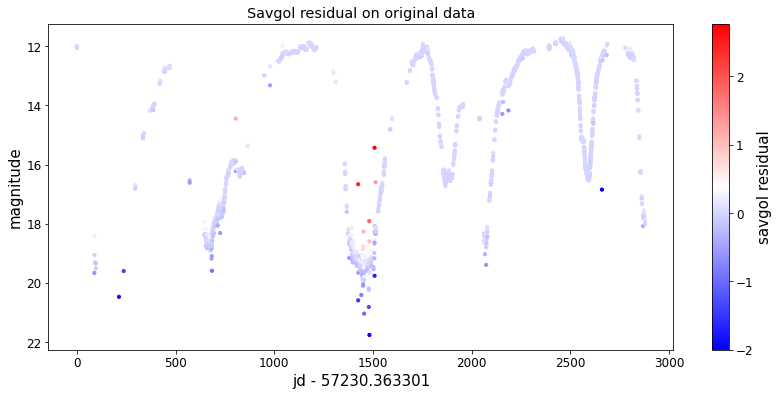

Std dev: 0.1847252883873899
95 percentile: 0.11005556777396841
99 percentile: 0.4567693581790459


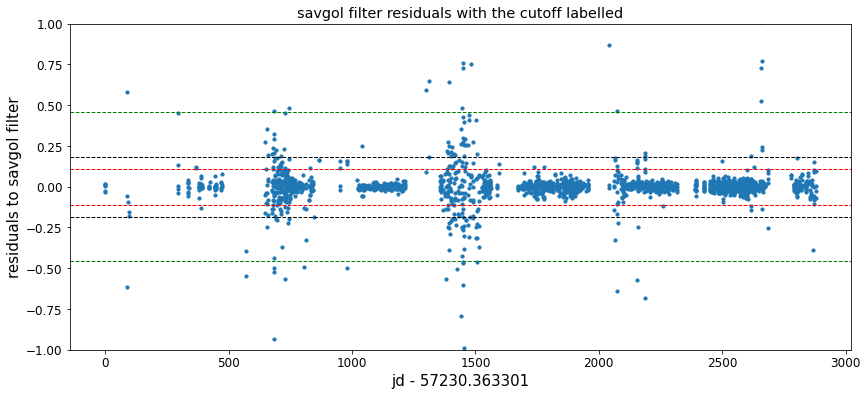

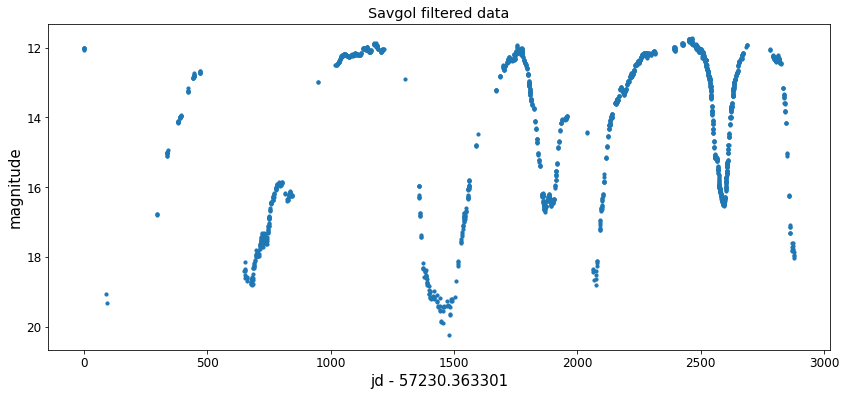

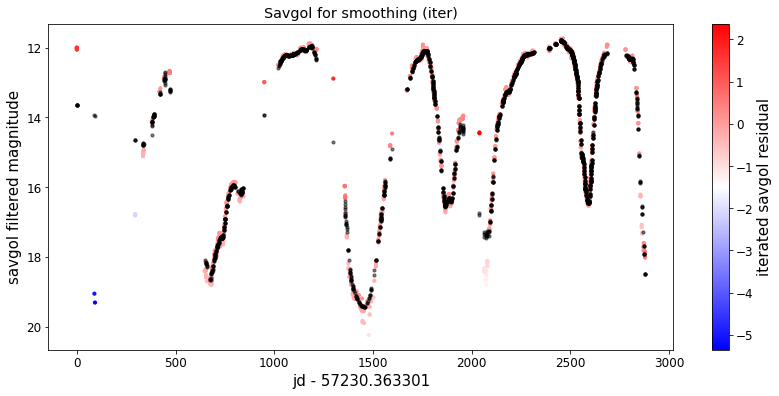

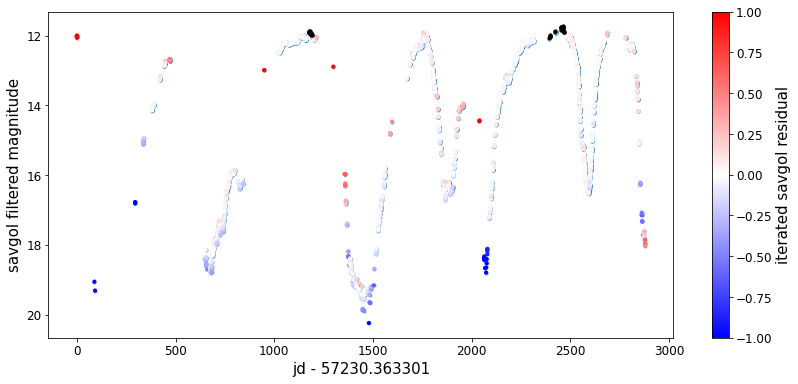

data resolution: 1.3404575924545876


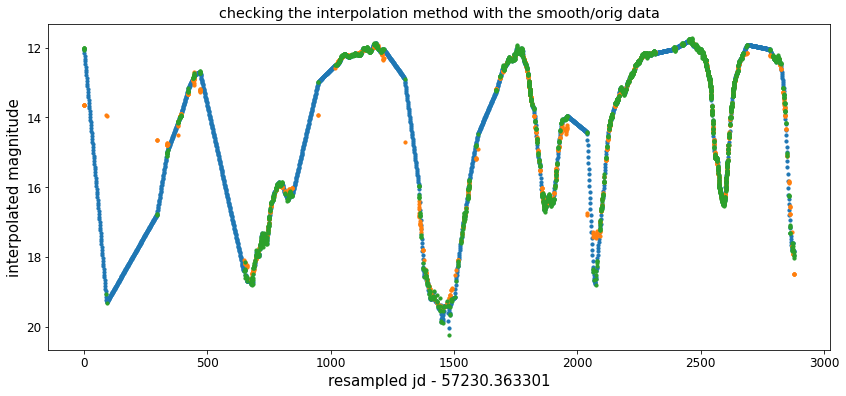

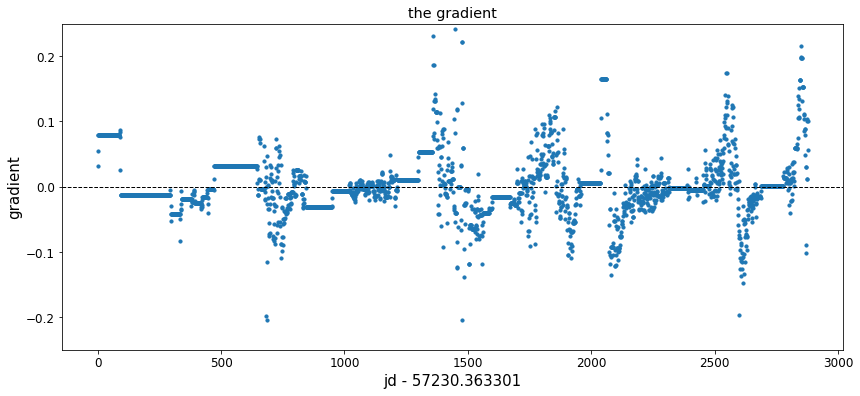

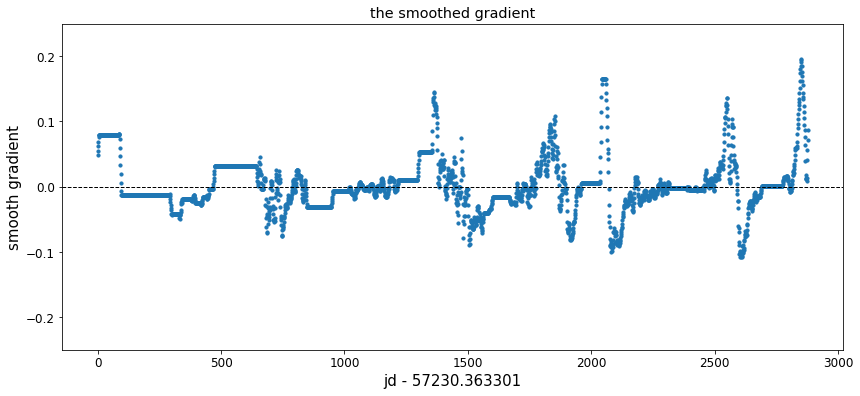

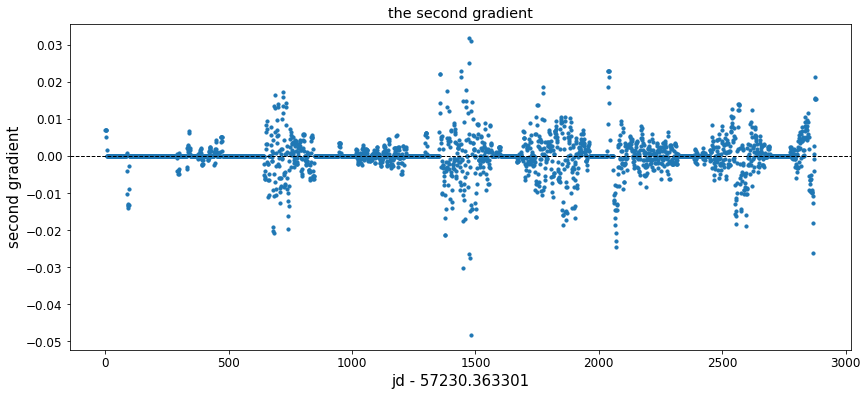

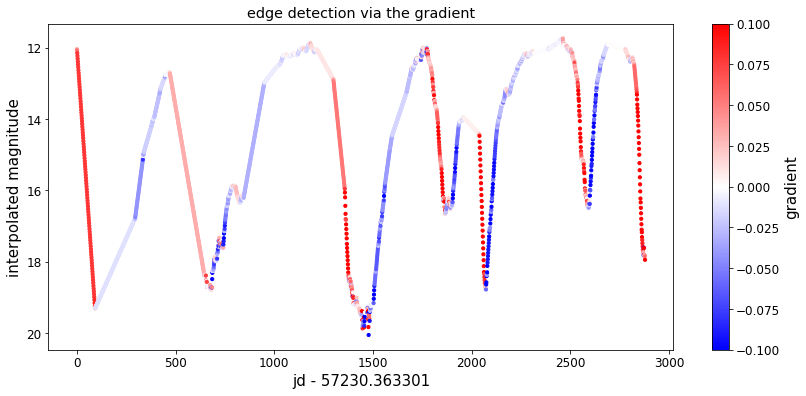

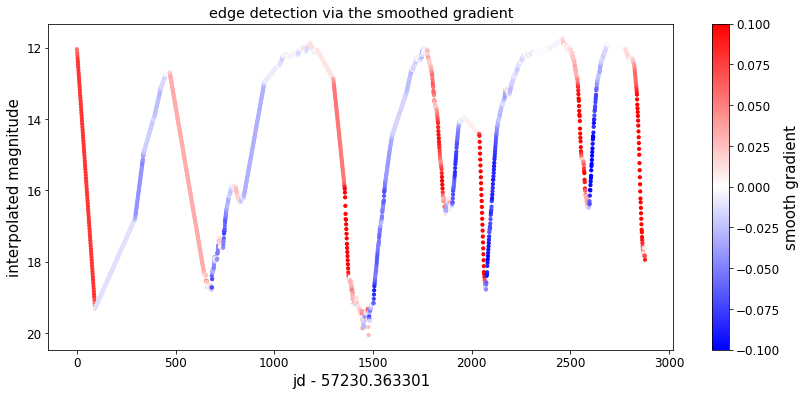

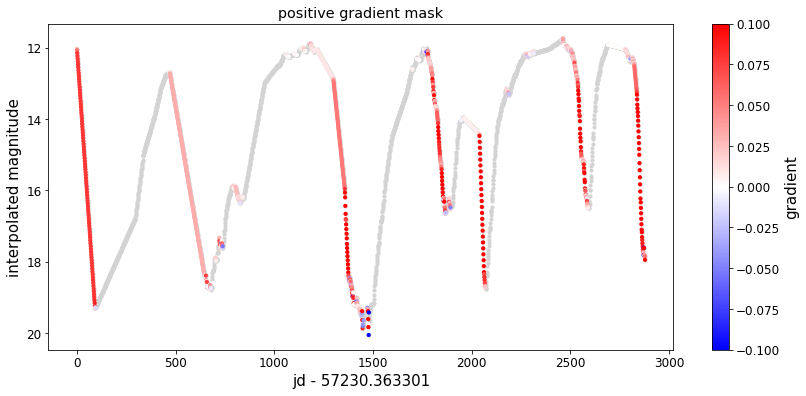

actually detecting the declines
0
12.044
7.223831788343208
468
12.704707587440046
5.980120184412714
1214
12.044496165267903
6.376320771326691
1383
18.486677133884406
0.72078321156771
1774
12.208447662956456
4.380577375245828
1959
13.967526742937649
4.764170447324405
2497
12.040621330395945
4.4488018193001455
end
2811
12.286276638602589
5.655723361397412
[19.26783179 18.68482777 18.42081694 19.20746035 16.58902504 18.73169719
 16.48942315 17.942     ]
[7.223831788343208, 5.980120184412714, 6.376320771326691, 0.72078321156771, 4.380577375245828, 4.764170447324405, 4.4488018193001455, 5.655723361397412]


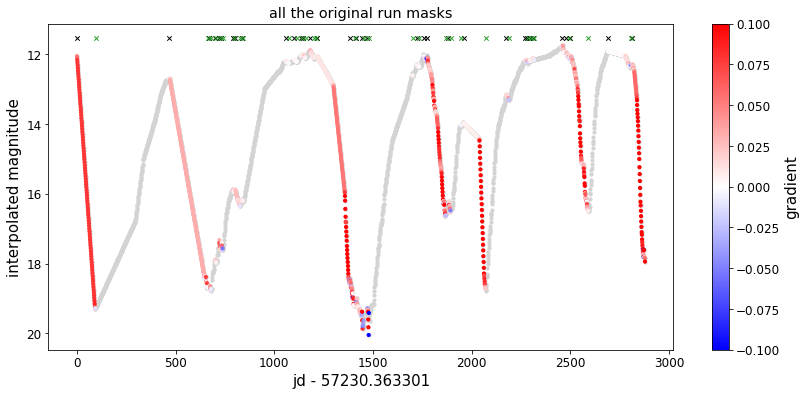

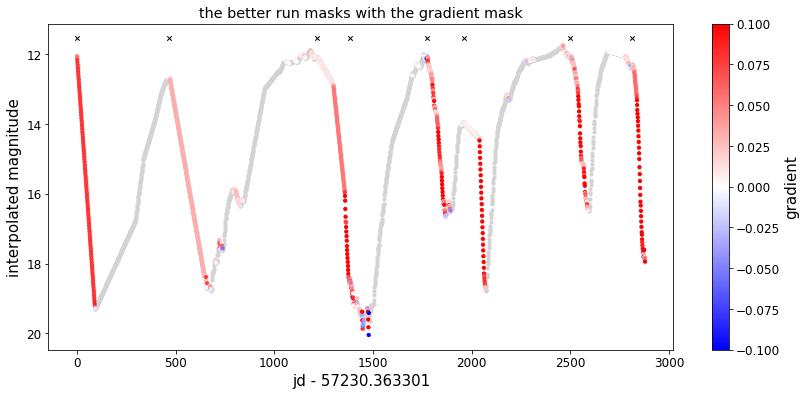

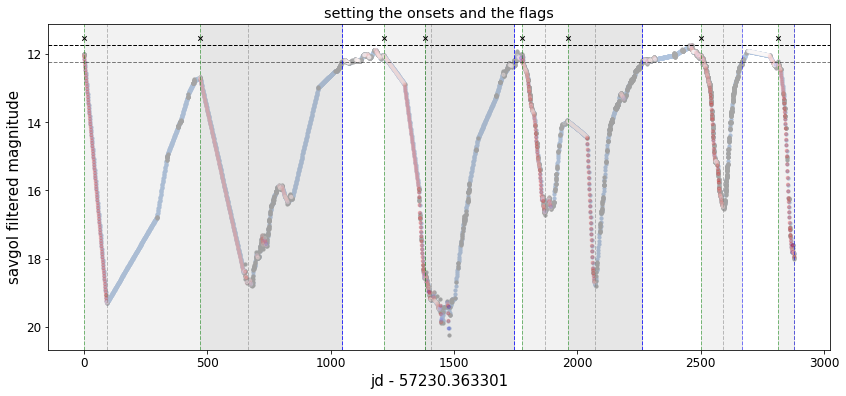

onsets
ends
2


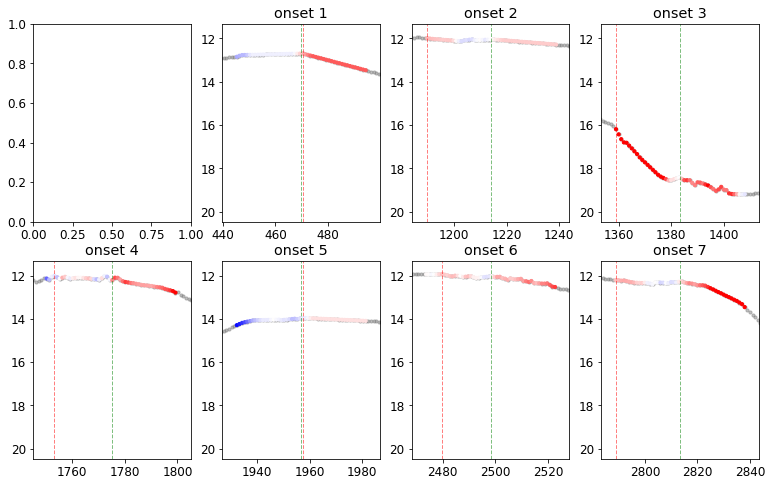

decline 2 big gap, changing index
[3.98307700e+00 5.58700000e-03 4.57999995e-04 9.16300000e-03
 1.00081620e+01 1.06500000e-02 8.45200000e-03 7.98800000e-03
 4.00642500e+00]


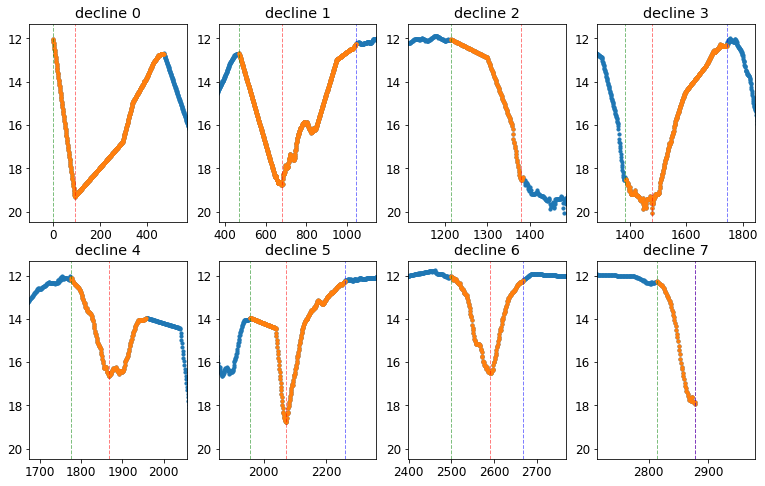

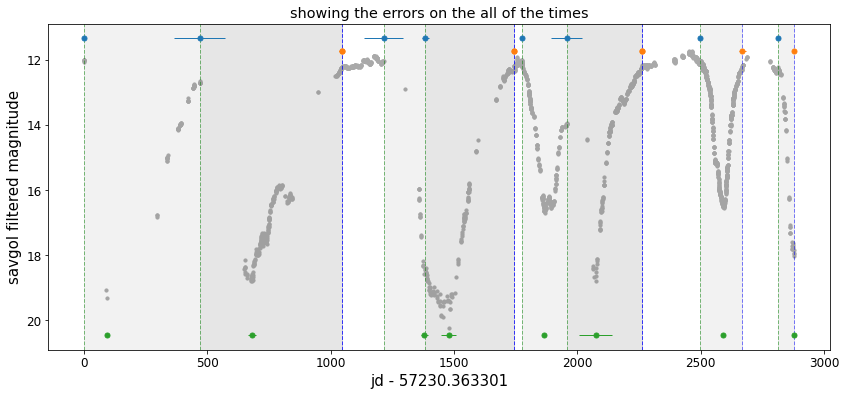

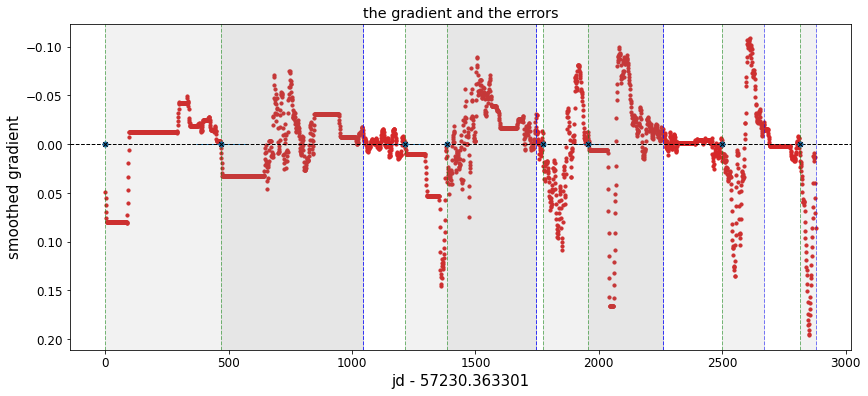

     onset_time   onset_err  onset_flag      end_time    end_err  end_flag  \
0  57230.363301         NaN         1.0  58275.557611   9.960608       0.0   
1  57700.205856  103.210065         0.0  58275.557611   9.960608       0.0   
2  58444.238956   79.204428         0.0  58974.498391   4.990704       0.0   
3  58613.552261   13.493175         0.0  58974.498391   4.990704       0.0   
4  59005.466054    3.065053         0.0  59491.293525   5.998458       0.0   
5  59187.212450   63.211107         0.0  59491.293525   5.998458       0.0   
6  59728.539197    7.426241         0.0  59898.200616  14.006479       0.0   
7  60043.616793    2.866035         0.0  60108.325752        NaN       1.0   

     depth_time  depth_err  decline_depth  min_mag  
0  57322.197025        NaN       7.061054   19.308  
1  57911.616573  15.469002       6.101000   18.801  
2  58609.569060  13.487044       6.542000   18.577  
3  58709.231139  30.008743       1.797000   20.238  
4  59096.477233   5.484995      

,onset_time,onset_err,onset_flag,end_time,end_err,end_flag,depth_time,depth_err,decline_depth,min_mag
0,57230.363301,NaN,1.0,58275.557611,9.960608,0.0,57322.197025,NaN,7.061054,19.308
1,57700.205856,103.210065,0.0,58275.557611,9.960608,0.0,57911.616573,15.469002,6.101000,18.801
2,58444.238956,79.204428,0.0,58974.498391,4.990704,0.0,58609.569060,13.487044,6.542000,18.577
3,58613.552261,13.493175,0.0,58974.498391,4.990704,0.0,58709.231139,30.008743,1.797000,20.238
4,59005.466054,3.065053,0.0,59491.293525,5.998458,0.0,59096.477233,5.484995,4.429000,16.652
5,59187.212450,63.211107,0.0,59491.293525,5.998458,0.0,59303.565061,66.192029,4.844000,18.791
6,59728.539197,7.426241,0.0,59898.200616,14.006479,0.0,59820.320907,3.454958,4.464000,16.493
7,60043.616793,2.866035,0.0,60108.325752,NaN,1.0,60108.325752,NaN,5.668000,17.942


In [28]:
decline_detection(oband,use_iter_smooth=False,debug_mode=True,decline_min_depth=0.5)

In [ ]:
decline_detection(oband,use_iter_smooth=False,debug_mode=True)#,
#                  savefile='/Users/ccra8514/Desktop/ASAS-RCB-21')

In [645]:
# decline_detection(oband,use_iter_smooth=True,debug_mode=True)#,
# #                  savefile='/Users/ccra8514/Desktop/ASAS-RCB-21')

In [59]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-21_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-7_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_EROS2-CG-RCB-10_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.312996,15.750,0.023,1820.0,42.0,o,0,1.77,251.87391,-15.42304,7376.48,8986.20,3.50,3.44,-76.1,-0.475,18.61,19.73,02a57228o0091o
1,57228.336591,15.729,0.022,1856.0,40.0,o,0,1.52,251.87391,-15.42304,5894.92,10454.92,3.50,3.23,-4.0,-0.472,18.60,19.72,02a57228o0116o
2,57228.340302,15.703,0.021,1900.0,40.0,o,0,1.74,251.87391,-15.42304,9112.80,733.87,3.67,3.31,89.9,-0.477,18.66,19.79,02a57228o0120o
3,57228.362466,15.758,0.026,1806.0,46.0,o,0,1.00,251.87391,-15.42304,5898.51,10460.16,3.45,3.16,-8.5,-0.478,18.62,19.72,02a57228o0144o
4,57228.366169,15.737,0.022,1842.0,40.0,o,0,1.58,251.87391,-15.42304,9114.39,738.79,3.64,3.23,-81.0,-0.471,18.68,19.82,02a57228o0148o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,60102.016247,17.698,0.097,302.0,29.0,o,0,1.08,251.87391,-15.42304,8482.84,8720.26,2.99,2.37,-18.1,-0.393,18.61,19.18,03a60102o0701o
2941,60102.055586,17.709,0.107,300.0,32.0,o,0,1.50,251.87391,-15.42304,8429.85,8798.32,3.58,2.80,-5.8,-0.429,18.31,18.99,03a60102o0747o
2942,60109.173979,18.482,0.085,147.0,12.0,c,0,3.07,251.87391,-15.42304,3660.82,2261.67,2.46,2.22,47.8,-0.384,19.34,21.39,04a60109o0493c
2943,60109.177839,18.499,0.081,145.0,12.0,c,0,3.04,251.87391,-15.42304,3682.33,2296.87,2.29,2.09,47.8,-0.390,19.40,21.37,04a60109o0500c


In [60]:
oband = atlas[atlas['f']=='o']
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.312996,15.750,0.023,1820.0,42.0,o,0,1.77,251.87391,-15.42304,7376.48,8986.20,3.50,3.44,-76.1,-0.475,18.61,19.73,02a57228o0091o
1,57228.336591,15.729,0.022,1856.0,40.0,o,0,1.52,251.87391,-15.42304,5894.92,10454.92,3.50,3.23,-4.0,-0.472,18.60,19.72,02a57228o0116o
2,57228.340302,15.703,0.021,1900.0,40.0,o,0,1.74,251.87391,-15.42304,9112.80,733.87,3.67,3.31,89.9,-0.477,18.66,19.79,02a57228o0120o
3,57228.362466,15.758,0.026,1806.0,46.0,o,0,1.00,251.87391,-15.42304,5898.51,10460.16,3.45,3.16,-8.5,-0.478,18.62,19.72,02a57228o0144o
4,57228.366169,15.737,0.022,1842.0,40.0,o,0,1.58,251.87391,-15.42304,9114.39,738.79,3.64,3.23,-81.0,-0.471,18.68,19.82,02a57228o0148o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161,60091.925509,18.020,0.075,225.0,17.0,o,0,4.50,251.87391,-15.42304,4170.15,5653.47,2.21,2.05,-30.2,-0.403,19.29,20.31,03a60092o0495o
2162,60091.933577,17.917,0.054,247.0,13.0,o,0,9.08,251.87391,-15.42304,4227.79,5730.06,2.37,2.12,-22.6,-0.403,19.26,20.41,03a60092o0512o
2163,60091.935140,17.860,0.054,261.0,14.0,o,0,6.59,251.87391,-15.42304,4249.28,5614.83,2.33,2.08,-28.8,-0.399,19.30,20.40,03a60092o0515o
2164,60102.016247,17.698,0.097,302.0,29.0,o,0,1.08,251.87391,-15.42304,8482.84,8720.26,2.99,2.37,-18.1,-0.393,18.61,19.18,03a60102o0701o


In [61]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band flux (ujy)')
# # plt.ylim(-100,1000)
# # plt.ylim(0.6,1.2)
# # plt.xlim(1000,2000)
# plt.show()

In [62]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band mag')
# # plt.ylim(top=1.2)
# # plt.ylim(0.6,1.2)
# # plt.xlim(1000,2000)
# plt.show()

In [63]:
oband.rename(columns={'mjd': 'jd', 'm': 'mag'},inplace=True)

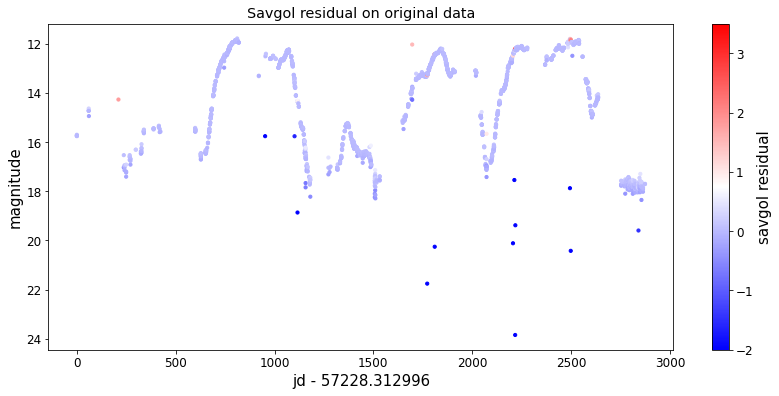

Std dev: 0.45389499833274377
95 percentile: 0.12298086233312233
99 percentile: 1.1998018832822408


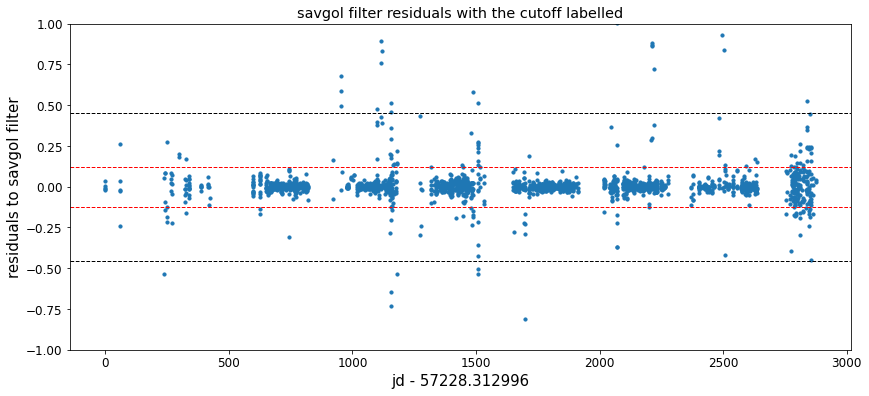

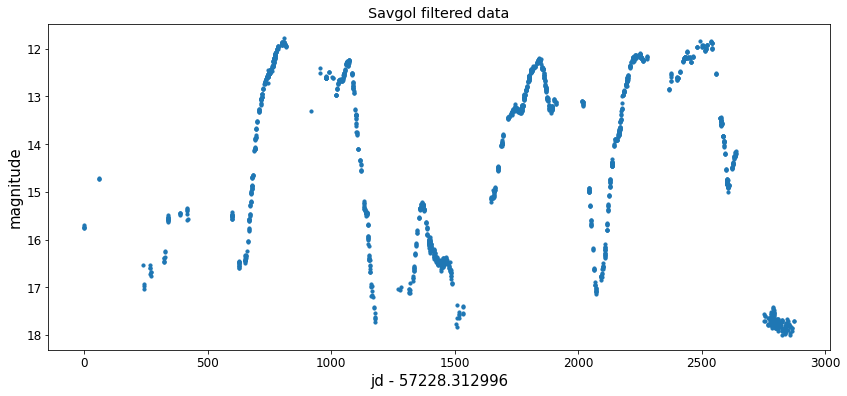

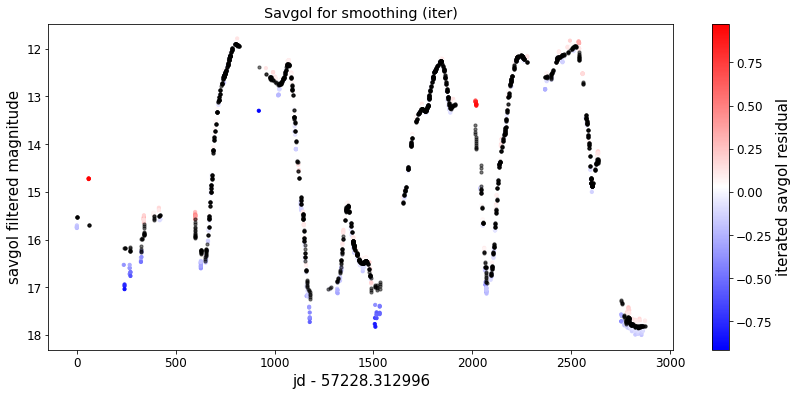

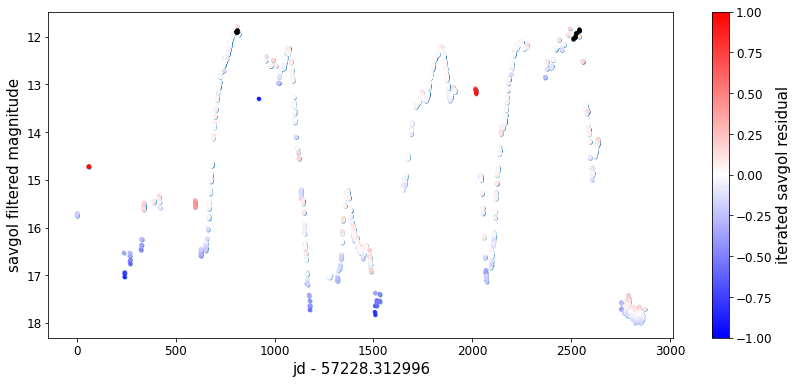

data resolution: 1.4513851464646472


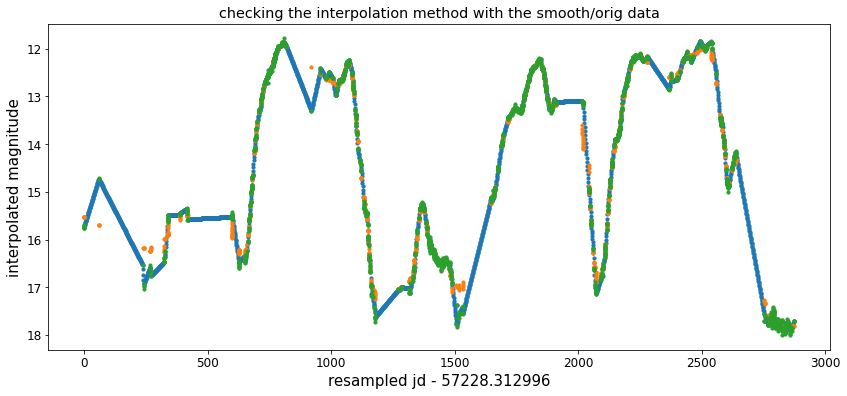

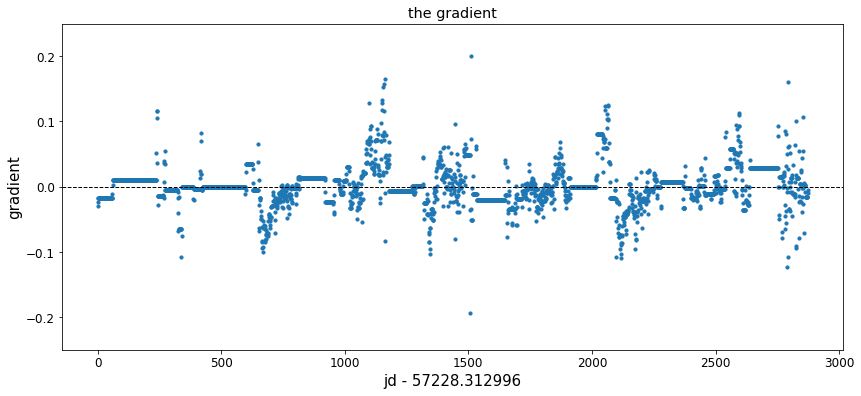

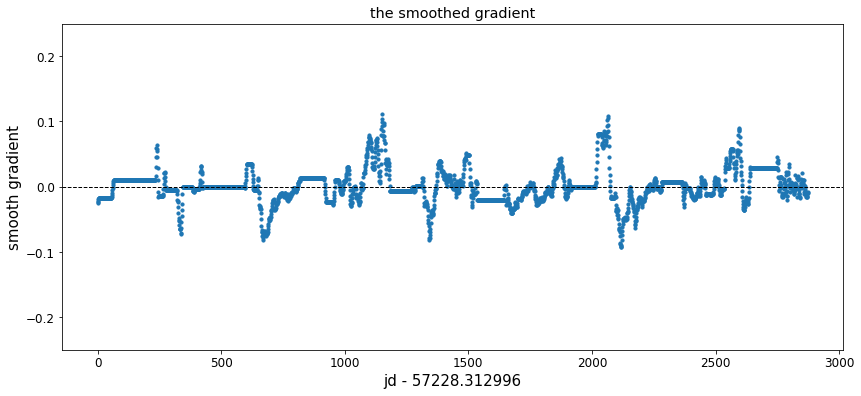

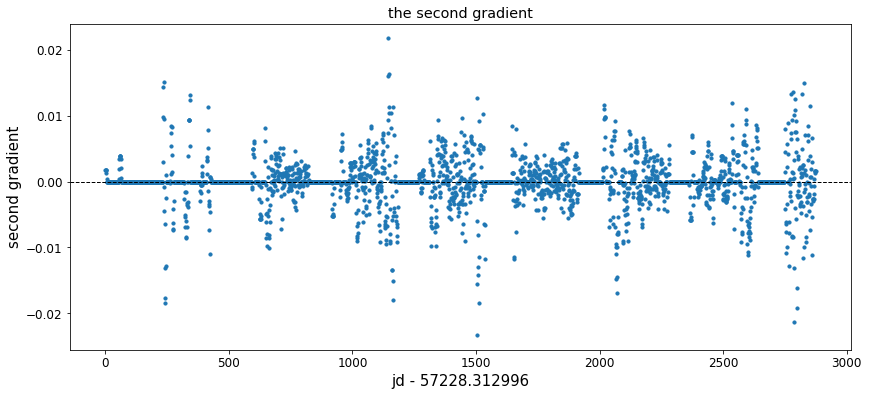

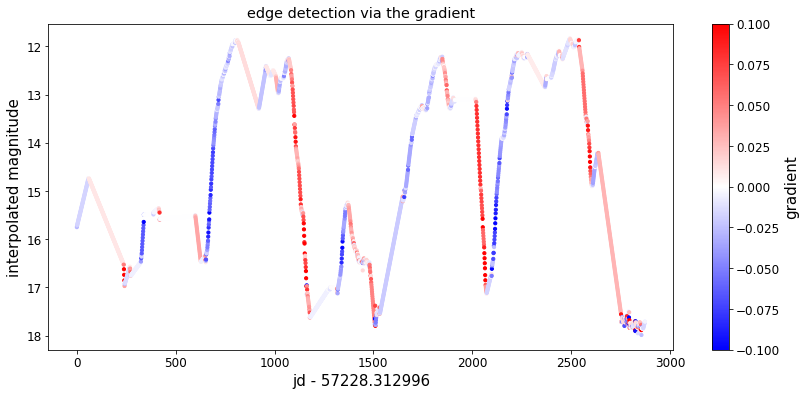

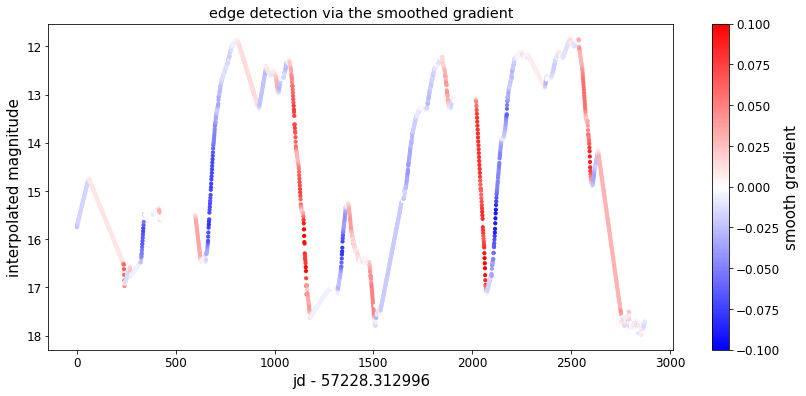

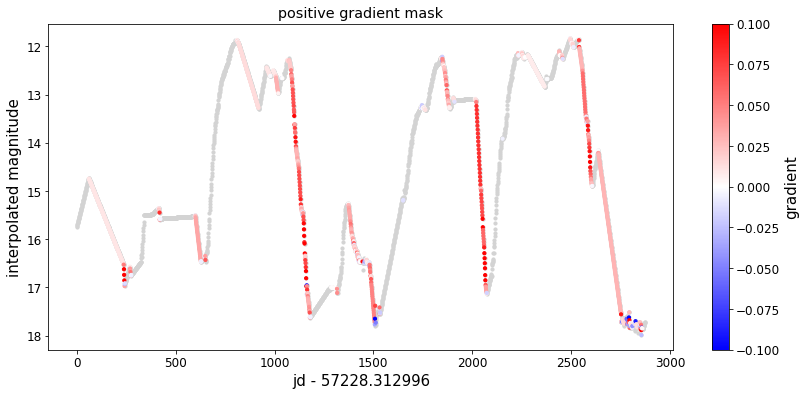

actually detecting the declines
beginning i=0
15.75
61
14.743020532612777
2.159106101554146
596
15.52453059085228
0.9292112053352213
808
11.871123840960793
1.4182556059969702
1073
12.283260725192743
5.317927722405976
1370
15.299760631493767
1.1723509028077697
1462
16.42731522620889
1.3709809863255344
1841
12.24516408942367
1.0411041162660197
2012
13.09161802390352
4.006021531667733
2535
11.858705028779188
3.0352298216268316
2634
14.211449829001769
3.4037176701645073
[14.74302053 16.90212663 16.4537418  13.28937945 17.60118845 16.47211153
 17.79829621 13.28626821 17.09763956 14.89393485 17.6151675 ]
[1.0069794673872234, 2.159106101554146, 0.9292112053352213, 1.4182556059969702, 5.317927722405976, 1.1723509028077697, 1.3709809863255344, 1.0411041162660197, 4.006021531667733, 3.0352298216268316, 3.4037176701645073]


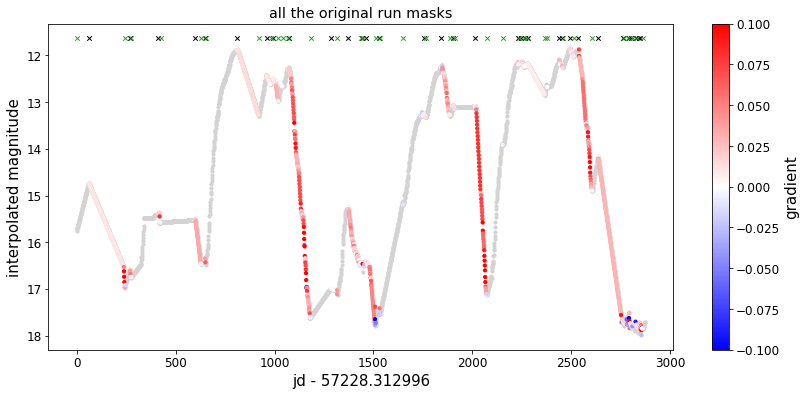

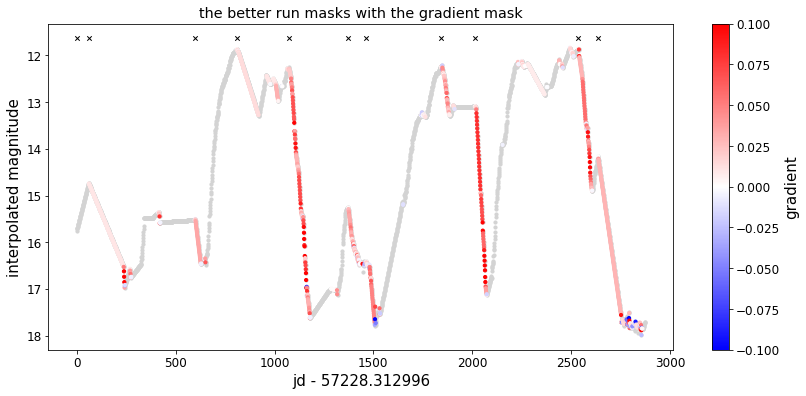

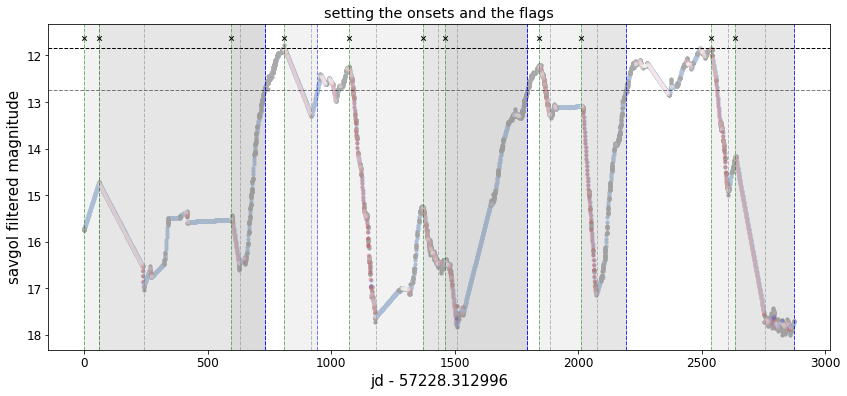

onsets
decline 4 big gap, changing index
[9.96560100e+00 1.07930000e-02 4.60999996e-04 1.02740000e-02
 4.60000003e-04 1.02790000e-02 4.60999996e-04 3.93723100e+00
 1.04360000e-02]
decline 7 big gap, changing index
[3.225000e-03 5.529000e-03 1.151200e-02 1.045913e+00 3.285000e-03
 5.524000e-03 1.349100e-02 3.920360e+00 5.548000e-03]
ends
3


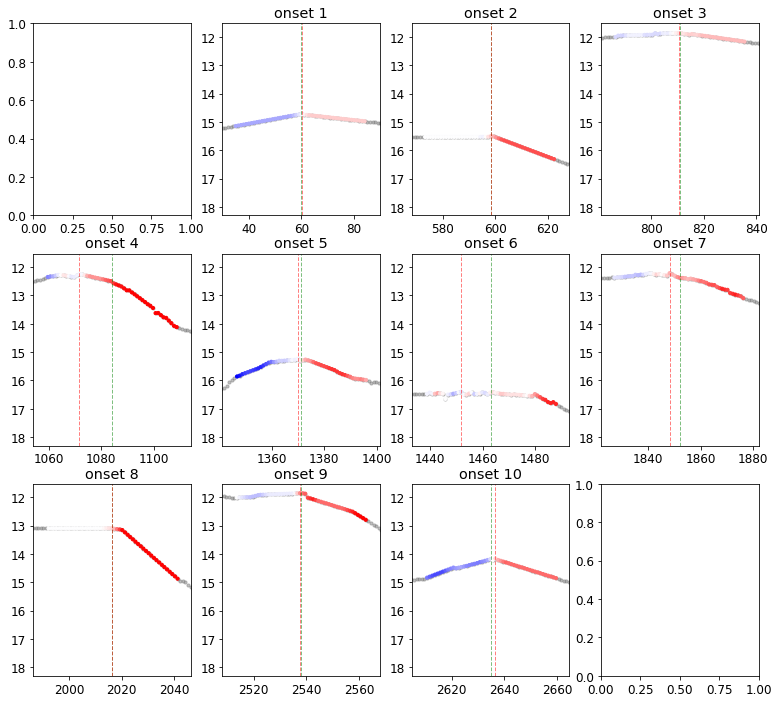

decline 4 big gap, changing index
[9.27377000e-01 1.05670000e-02 1.04750000e-02 1.09150000e-02
 1.97320300e+00 9.96560100e+00 1.07930000e-02 4.60999996e-04
 1.02740000e-02]


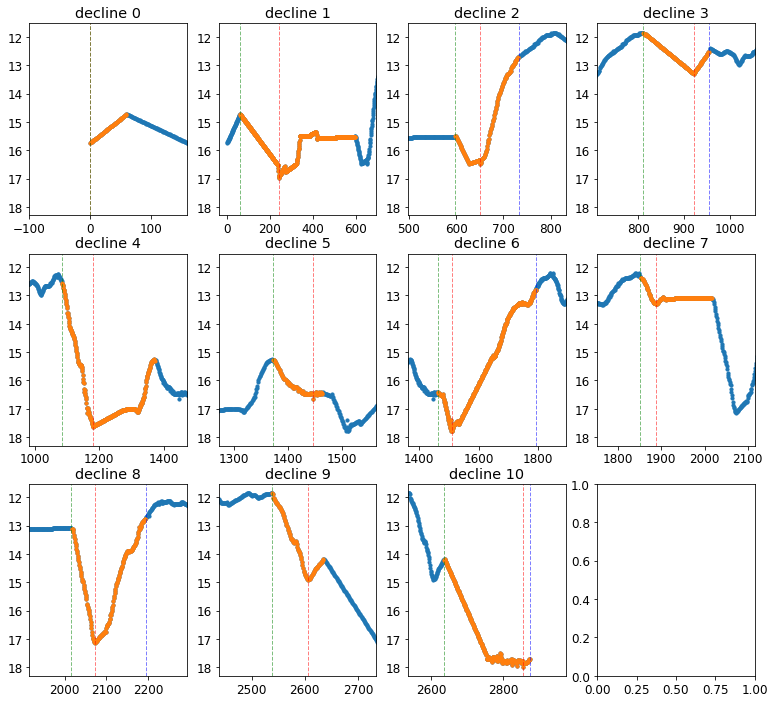

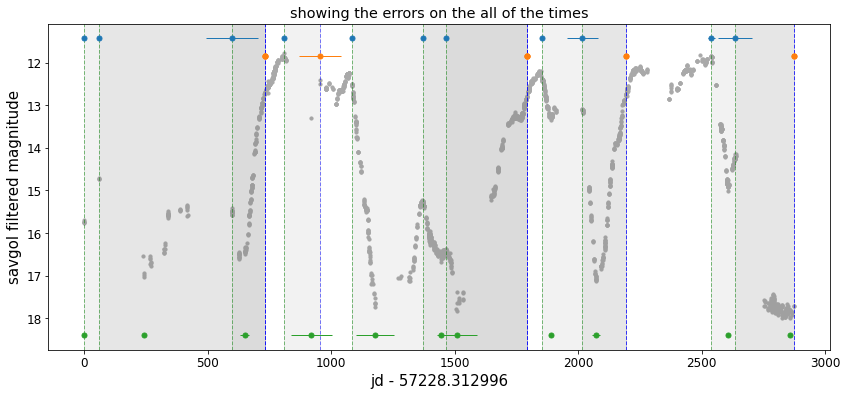

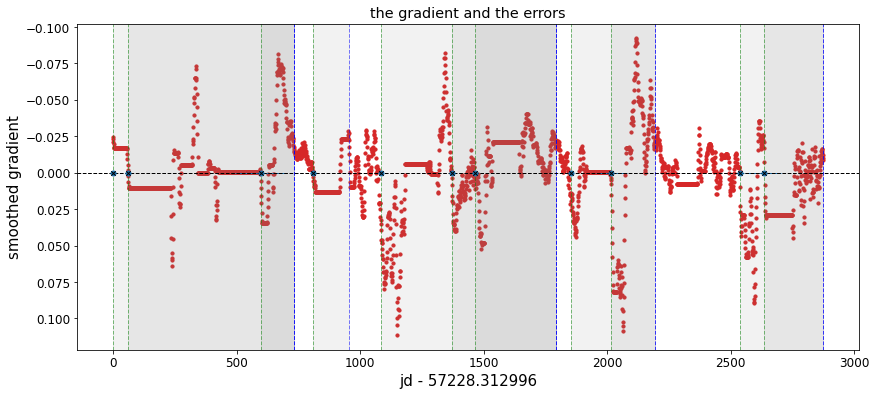

      onset_time   onset_err  onset_flag      end_time    end_err  end_flag  \
0   57228.312996         NaN         1.0  57960.349266   8.969138       0.0   
1   57288.263288         NaN         0.0  57960.349266   8.969138       0.0   
2   57826.534563  105.612185         0.0  57960.349266   8.969138       0.0   
3   58039.200608    6.997112         0.0  58182.663329  84.620729       0.0   
4   58312.412224    8.989095         0.0  59020.429382   6.443039       0.0   
5   58599.549978    6.534906         0.0  59020.429382   6.443039       0.0   
6   58691.349491    5.507713         0.0  59020.429382   6.443039       0.0   
7   59080.287564    6.493476         0.0  59421.425271   6.460940       0.0   
8   59244.635723   63.214822         0.0  59421.425271   6.460940       0.0   
9   59766.356327   13.964629         0.0  60102.055586        NaN       1.0   
10  59863.018790   69.161421         0.0  60102.055586        NaN       1.0   

      depth_time  depth_err  decline_depth  min_mag

,onset_time,onset_err,onset_flag,end_time,end_err,end_flag,depth_time,depth_err,decline_depth,min_mag
0,57228.312996,NaN,1.0,57960.349266,8.969138,0.0,57228.312996,NaN,3.014076,15.750
1,57288.263288,NaN,0.0,57960.349266,8.969138,0.0,57469.477275,NaN,2.242000,16.974
2,57826.534563,105.612185,0.0,57960.349266,8.969138,0.0,57879.616224,17.984490,0.958000,16.482
3,58039.200608,6.997112,0.0,58182.663329,84.620729,0.0,58148.665802,84.134203,1.434000,13.300
4,58312.412224,8.989095,0.0,59020.429382,6.443039,0.0,58406.243000,77.701462,5.127000,17.631
5,58599.549978,6.534906,0.0,59020.429382,6.443039,0.0,58674.248847,6.516594,1.375000,16.665
6,58691.349491,5.507713,0.0,59020.429382,6.443039,0.0,58738.295235,82.130647,1.409000,17.828
7,59080.287564,6.493476,0.0,59421.425271,6.460940,0.0,59117.247348,7.997210,0.905000,13.297
8,59244.635723,63.214822,0.0,59421.425271,6.460940,0.0,59300.517828,15.486111,4.042000,17.133
9,59766.356327,13.964629,0.0,60102.055586,NaN,1.0,59834.008363,1.940181,3.032000,14.885


In [64]:
decline_detection(oband,use_iter_smooth=False,debug_mode=True)#,
#                  savefile='/Users/ccra8514/Desktop/EROS2-CG-RCB-10')